In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Activation ,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Flatten ,Dropout
import tensorflow as tf


In [2]:
image_size = 32
num_channels = 3
num_features = image_size * image_size * num_channels
num_classes = 10

num_train = 49000

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Train data shape: {}'.format(X_train.shape))
print('Test  data shape: {}'.format(X_test.shape))

170500096/170498071 [==============================] - 4s 0us/step
Train data shape: (50000, 32, 32, 3)
Test  data shape: (10000, 32, 32, 3)


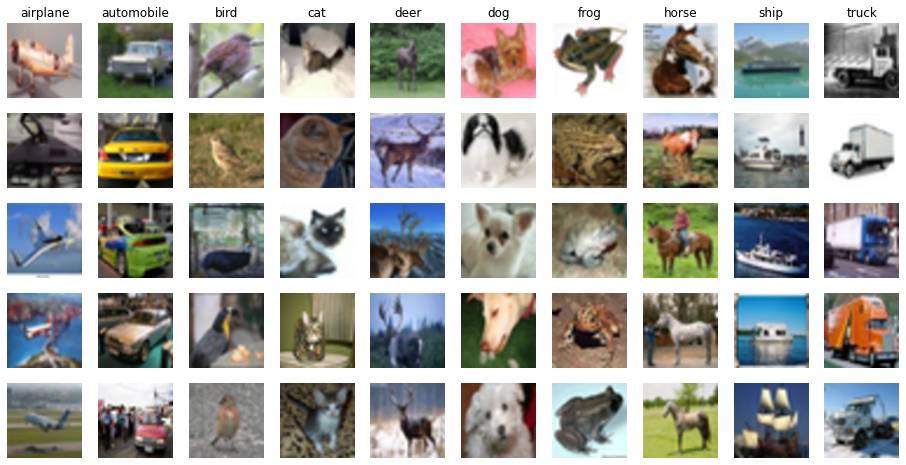

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
samples_per_class = 5

plt.figure(figsize=(16, 8))

for cls, name in enumerate(class_names):
    idxs = np.flatnonzero(y_train == cls)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(samples_per_class, num_classes, i * num_classes + cls + 1)
        plt.imshow(X_train[idx], interpolation='spline16')
        plt.axis('off')
        if i == 0:
            plt.title(class_names[cls])

In [6]:
# convert pixel range from [0, 255] to [0., 1.]
X_train = X_train.astype('float32')
x_test  = X_test.astype('float32')

mu = np.mean(X_train, axis=0)

X_train -= mu
X_train /= 255.0

x_test -= mu
x_test /= 255.0

In [7]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test,  num_classes)

print(y_train.shape)
print(y_test.shape)

(50000, 10)
(10000, 10)


In [8]:
def create_cnn():
    model = Sequential()

    # Conv Block 1
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=X_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
   

    # Conv Block 2
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    

    # Conv Block 3
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Conv2D(256, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    
    # Classifier
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

model = create_cnn()

#print model
#model.summary()

In [138]:
BATCH_SIZE = 200
STEPS_PER_EPOCH =len(X_train)//BATCH_SIZE

In [140]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.0001,
  decay_steps=STEPS_PER_EPOCH*48,
  decay_rate=0.078,
  staircase=False)



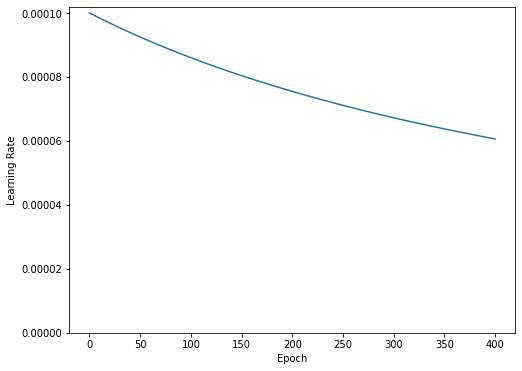

In [141]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [142]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [145]:
model.fit(X_train[:num_train], y_train[:num_train],
          batch_size=64,
          epochs=10,
          validation_data=(X_train[num_train:], y_train[num_train:]))

Epoch 1/10
766/766 [==============================] - 9s 11ms/step - loss: 0.0043 - accuracy: 0.9986 - val_loss: 0.9857 - val_accuracy: 0.8870
Epoch 2/10
766/766 [==============================] - 9s 11ms/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 0.9851 - val_accuracy: 0.8890
Epoch 3/10
766/766 [==============================] - 9s 11ms/step - loss: 0.0036 - accuracy: 0.9988 - val_loss: 0.9934 - val_accuracy: 0.8910
Epoch 4/10
766/766 [==============================] - 9s 11ms/step - loss: 0.0039 - accuracy: 0.9988 - val_loss: 0.9901 - val_accuracy: 0.8920
Epoch 5/10
766/766 [==============================] - 9s 11ms/step - loss: 0.0031 - accuracy: 0.9990 - val_loss: 0.9816 - val_accuracy: 0.8910
Epoch 6/10
766/766 [==============================] - 9s 11ms/step - loss: 0.0039 - accuracy: 0.9987 - val_loss: 0.9932 - val_accuracy: 0.8890
Epoch 7/10
766/766 [==============================] - 8s 11ms/step - loss: 0.0031 - accuracy: 0.9988 - val_loss: 1.0069 - val_accuracy: 0.8870

In [146]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
y_pred = model.predict(x_test)
AUC = roc_auc_score(y_test,  y_pred.round())
print(AUC)

0.9263388888888888
